In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from scipy import stats

## Prepare data

In [2]:
data_3 = pd.read_csv("result_0.3_full.csv", index_col=0)
data_4 = pd.read_csv("result_0.4_full.csv", index_col=0)
data_5 = pd.read_csv("result_0.5_full.csv", index_col=0)
data_6 = pd.read_csv("result_0.6_full.csv", index_col=0)
data_7 = pd.read_csv("result_0.7_full.csv", index_col=0)
data_3_5 = pd.read_csv("result_0.35_full.csv", index_col=0)
data_4_5 = pd.read_csv("result_0.45_full.csv", index_col=0)
data_5_5 = pd.read_csv("result_0.55_full.csv", index_col=0)
data_6_5 = pd.read_csv("result_0.65_full.csv", index_col=0)
data_7_5 = pd.read_csv("result_0.75_full.csv", index_col=0)
data_agg = pd.concat([data_3, data_4], axis=0)
data_agg = pd.concat([data_agg, data_5], axis=0)
data_agg = pd.concat([data_agg, data_6], axis=0)
data_agg = pd.concat([data_agg, data_7], axis=0)
data_agg = pd.concat([data_agg, data_3_5], axis=0)
data_agg = pd.concat([data_agg, data_4_5], axis=0)
data_agg = pd.concat([data_agg, data_5_5], axis=0)
data_agg = pd.concat([data_agg, data_6_5], axis=0)
data_agg = pd.concat([data_agg, data_7_5], axis=0)

## Train Neural Network

In [3]:
seed = 1
learning_rate = 0.001
batch_size = 50
n_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_agg[['newman_p', 'threshold', 'policy_power']], data_agg['I_P_N_m'],
                                                    test_size=0.2, random_state=42)
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std
x_train = np.array(X_train)
y_train = np.array(y_train)
x_test = np.array(X_test)
y_test = np.array(y_test)

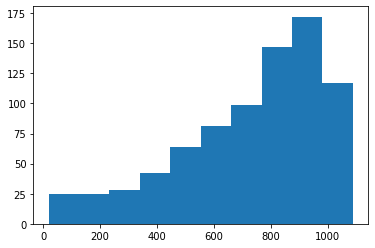

In [5]:
plt.hist(y_train)
plt.show()

In [6]:
trainfoldx = torch.tensor(x_train, dtype=torch.float32).to(device)
trainfoldy = torch.tensor(y_train, dtype=torch.float32).to(device)
x_val_fold = torch.tensor(x_test, dtype=torch.float32).to(device)
y_val_fold = torch.tensor(y_test[:, np.newaxis], dtype=torch.float32).to(device)
train = torch.utils.data.TensorDataset(trainfoldx, trainfoldy)
valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

In [7]:
class DP(torch.nn.Module):

    def __init__(self):
        super(DP, self).__init__()

        self.linear_1 = nn.Linear(3, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 32)
        self.linear_out = nn.Linear(32, 1)

    def forward(self, x):
        out = self.linear_1(x)
        out = out * torch.sigmoid(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_2(out)
        out = out * torch.sigmoid(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_3(out)
        out = out * torch.sigmoid(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_out(out)
        return out

In [8]:
def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 3).to(device)  # Change here for different features number
            targets = targets.to(device)
            logits = model.forward(features)
            loss = loss_fn(torch.squeeze(logits), targets)
            num_examples += targets.size()[0]
            curr_loss += loss * targets.size()[0]  # MSEloss is an average loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [9]:
train_cost = []
test_cost = []
start_time = time.time()
minibatch_cost = []
torch.manual_seed(seed)
model = DP()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,
                             weight_decay=1e-8)  # Change here for different optimizer ###
loss_fn = torch.nn.MSELoss()  # Change here for different loss function ###
for epoch in range(n_epochs):
    start = time.time()
    model.train()
    grand_loss = 0
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        logits = model(x_batch)
        loss = loss_fn(torch.squeeze(logits), y_batch)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not batch_idx % 10:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                  % (epoch + 1, n_epochs, batch_idx, len(train_loader), math.sqrt(loss.item())))

            # evaluation
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    cost_test = compute_epoch_loss(model, valid_loader)
    train_cost.append(cost.item())
    test_cost.append(cost_test.item())

    print('Epoch: %03d/%03d Train Cost: %.4f Test Cost: %.4f' % (
        epoch + 1, n_epochs, math.sqrt(cost), math.sqrt(cost_test)))
    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

Epoch: 001/100 | Batch 000/016 | Loss: 759.5527
Epoch: 001/100 | Batch 010/016 | Loss: 808.2153


C:\Users\wangj\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([50, 1])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001/100 Train Cost: 724.7890 Test Cost: 730.5057
Time elapsed: 0.01 min
Epoch: 002/100 | Batch 000/016 | Loss: 715.8071
Epoch: 002/100 | Batch 010/016 | Loss: 500.4971
Epoch: 002/100 Train Cost: 158.0524 Test Cost: 333.9406
Time elapsed: 0.01 min
Epoch: 003/100 | Batch 000/016 | Loss: 308.6775
Epoch: 003/100 | Batch 010/016 | Loss: 305.1892
Epoch: 003/100 Train Cost: 218.5938 Test Cost: 345.5034
Time elapsed: 0.02 min
Epoch: 004/100 | Batch 000/016 | Loss: 303.7645
Epoch: 004/100 | Batch 010/016 | Loss: 270.7851
Epoch: 004/100 Train Cost: 116.3402 Test Cost: 339.9006
Time elapsed: 0.02 min
Epoch: 005/100 | Batch 000/016 | Loss: 325.7242
Epoch: 005/100 | Batch 010/016 | Loss: 313.5682
Epoch: 005/100 Train Cost: 148.3249 Test Cost: 318.9773
Time elapsed: 0.02 min
Epoch: 006/100 | Batch 000/016 | Loss: 310.0284
Epoch: 006/100 | Batch 010/016 | Loss: 284.8154
Epoch: 006/100 Train Cost: 136.2767 Test Cost: 333.5329
Time elapsed: 0.03 min
Epoch: 007/100 | Batch 000/016 | Loss: 305.490

Epoch: 048/100 | Batch 010/016 | Loss: 298.7220
Epoch: 048/100 Train Cost: 47.8086 Test Cost: 333.7274
Time elapsed: 0.18 min
Epoch: 049/100 | Batch 000/016 | Loss: 253.1801
Epoch: 049/100 | Batch 010/016 | Loss: 295.3220
Epoch: 049/100 Train Cost: 100.2062 Test Cost: 317.5525
Time elapsed: 0.18 min
Epoch: 050/100 | Batch 000/016 | Loss: 270.2522
Epoch: 050/100 | Batch 010/016 | Loss: 262.2521
Epoch: 050/100 Train Cost: 111.1823 Test Cost: 329.5924
Time elapsed: 0.19 min
Epoch: 051/100 | Batch 000/016 | Loss: 296.4253
Epoch: 051/100 | Batch 010/016 | Loss: 269.4636
Epoch: 051/100 Train Cost: 114.0917 Test Cost: 315.3661
Time elapsed: 0.19 min
Epoch: 052/100 | Batch 000/016 | Loss: 318.9863
Epoch: 052/100 | Batch 010/016 | Loss: 325.1244
Epoch: 052/100 Train Cost: 93.4208 Test Cost: 327.2705
Time elapsed: 0.20 min
Epoch: 053/100 | Batch 000/016 | Loss: 221.8386
Epoch: 053/100 | Batch 010/016 | Loss: 259.5513
Epoch: 053/100 Train Cost: 62.7646 Test Cost: 316.3798
Time elapsed: 0.20 min
E

Epoch: 095/100 | Batch 000/016 | Loss: 251.3404
Epoch: 095/100 | Batch 010/016 | Loss: 213.6284
Epoch: 095/100 Train Cost: 124.5346 Test Cost: 325.5422
Time elapsed: 0.36 min
Epoch: 096/100 | Batch 000/016 | Loss: 259.7948
Epoch: 096/100 | Batch 010/016 | Loss: 277.2569
Epoch: 096/100 Train Cost: 40.4176 Test Cost: 332.1104
Time elapsed: 0.37 min
Epoch: 097/100 | Batch 000/016 | Loss: 277.9591
Epoch: 097/100 | Batch 010/016 | Loss: 242.9516
Epoch: 097/100 Train Cost: 62.6399 Test Cost: 327.2649
Time elapsed: 0.37 min
Epoch: 098/100 | Batch 000/016 | Loss: 271.9642
Epoch: 098/100 | Batch 010/016 | Loss: 235.3085
Epoch: 098/100 Train Cost: 101.5554 Test Cost: 320.0184
Time elapsed: 0.37 min
Epoch: 099/100 | Batch 000/016 | Loss: 215.2714
Epoch: 099/100 | Batch 010/016 | Loss: 280.3261
Epoch: 099/100 Train Cost: 66.6719 Test Cost: 319.7100
Time elapsed: 0.38 min
Epoch: 100/100 | Batch 000/016 | Loss: 288.9292
Epoch: 100/100 | Batch 010/016 | Loss: 282.0112
Epoch: 100/100 Train Cost: 79.14

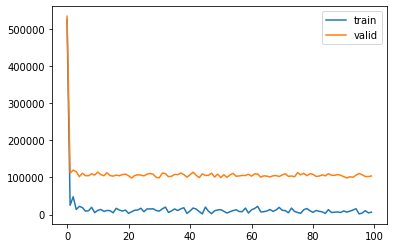

In [10]:
fig, ax = plt.subplots()
ax.plot(train_cost, label='train')
ax.plot(test_cost, label='valid')
ax.legend()
plt.show()

## Condition 

In [11]:
try_new = list(X_train.newman_p.value_counts().index)
try_pol = list(X_train.policy_power.value_counts().index)

In [12]:
# Preform the condition and do operation here by changing value target, fix_thr and do_thr
target = 900  # condition on IPN
fix_thr = 1  # condition on MMT
do_thr = -1  # do on MMT
comb = []
condition = []
for i_new in try_new:
    for i_pol in try_pol:
        sample = [i_new, fix_thr, i_pol]
        sample = np.array(sample)
        result = model(torch.tensor(sample, dtype=torch.float32).to(device))
        if target - 30 < result < target + 30:
            condition.extend(np.array(result.cpu().detach()))
            sample[1] = do_thr
            comb.append(sample)

In [13]:
cache = (comb * std.values + mean.values)[:, [0, 2]]
print("Combinations are:", cache[cache[:, 1] != 0])

Combinations are: [[0.55 0.1 ]
 [0.7  0.1 ]
 [0.7  0.2 ]
 [0.6  0.1 ]
 [0.75 0.3 ]
 [0.75 0.2 ]
 [0.65 0.1 ]
 [0.65 0.2 ]]


## Do

In [14]:
expect = []
res_do = []
for i in comb:
    if i[2] != 0:
        feed = torch.tensor(i, dtype=torch.float32).to(device)
        expect.extend(np.array(model(feed).cpu().detach()))
        res_do.append(np.array(model(feed).cpu().detach()))

In [15]:
print("The mean of do ouput is:", np.mean(expect))

The mean of do ouput is: 908.2183


In [17]:
print("The t-test result is:", stats.ttest_ind(res_do, condition, equal_var=False))

The t-test result is: Ttest_indResult(statistic=array([1.1398029], dtype=float32), pvalue=array([0.26917231]))
